In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import missingno as msno
from collections import Counter
from itertools import chain, combinations
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, make_scorer

In [2]:
data = pd.read_csv("newdata3.csv", engine='python').drop(['Unnamed: 0'], axis = 1)
dep_data = data.copy()

In [3]:
dep_num = np.array([12, 11, 10, 4])
no_dep_num = np.setdiff1d(range(13), dep_num)

dep_data[['prim_diag', 'secd_diag']] = dep_data[['prim_diag', 'secd_diag']].replace(list(no_dep_num), 0)
dep_data[['prim_diag', 'secd_diag']] = dep_data[['prim_diag', 'secd_diag']].replace(list(dep_num), 1)

In [4]:
full = data.dropna(axis = 0, how = 'any')
dep = [x for x in data.columns if 'dep' in x or 'diag' in x or 'panic' in x]
dep_data['dep'] = dep_data['secd_diag'] + dep_data['prim_diag'] + 0 * dep_data['has_dep_diag']
dep_data['dep'] = dep_data['dep'].replace(range(2, 4), 1)
full = dep_data.dropna(axis = 0, how = 'any')
dep = [x for x in data.columns if 'dep' in x or 'diag' in x or 'panic' in x]

has_dep = full.query('dep == 1')
no_dep = full.query('dep == 0')
size = int(np.round(0.8 * min(len(has_dep), len(no_dep))))
sample = has_dep.sample(size).append(no_dep.sample(size))

sample = sample.sort_index()
sample = sample.reset_index(drop = True)

X = sample.drop(dep, axis = 1).drop('dep', axis = 1)
y = sample['dep']

C:\Users\moham\AppData\Local\Temp/ipykernel_24904/2576254332.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample = has_dep.sample(size).append(no_dep.sample(size))


In [5]:
params = {'C': np.logspace(-5, 2, 7)}

def optimise(clf, params, X, y, verb):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid = GridSearchCV(clf, params, scoring = 'f1_micro', n_jobs = 1, verbose = verb)
    grid.fit(X, y)
    return grid

## Model on normal data

In [6]:
clf = LogisticRegression(penalty = 'l2', max_iter = 1000)

grid = optimise(clf, params, X, y, 0)

In [7]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

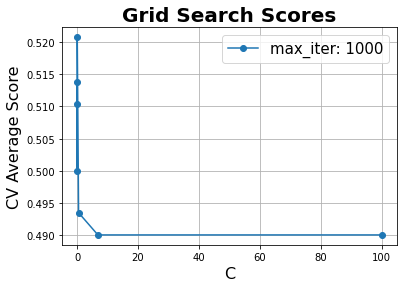

In [8]:
plot_grid_search(grid.cv_results_, params['C'], [1000], 'C', 'max_iter')

In [9]:
grid.best_score_

0.5207481005260082

## Model on PCA data

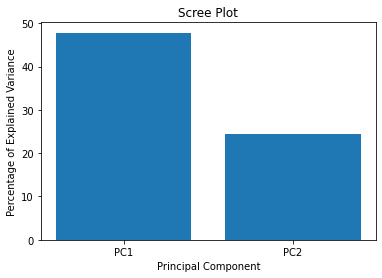

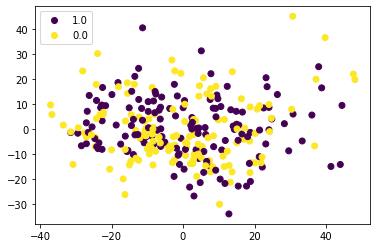

In [10]:
pca = PCA(2)
X_pca = pca.fit_transform(X)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)] 
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

plot = plt.scatter(X_pca[:,0], X_pca[:,1], c=y)
plt.legend(handles=plot.legend_elements()[0], labels=list(y.unique()))
plt.show()

In [11]:
clf = LogisticRegression(penalty = 'l2', max_iter = 1000)

grid = optimise(clf, params, X_pca, y, 0)
grid.best_score_

0.5273524254821742

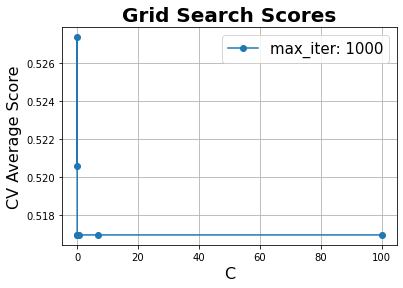

In [12]:
plot_grid_search(grid.cv_results_, params['C'], [1000], 'C', 'max_iter')

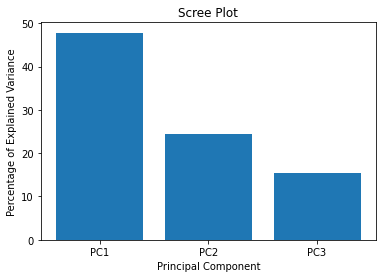

In [13]:
pca = PCA(3)
X_pca = pca.fit_transform(X)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)] 
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

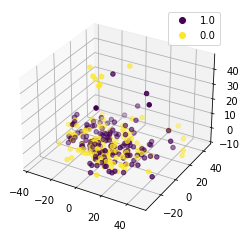

In [14]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c = y)
plt.legend(handles=plot.legend_elements()[0], labels=list(y.unique()))
plt.show()

In [15]:
clf = LogisticRegression(penalty = 'l2', max_iter = 1000)

grid = optimise(clf, params, X_pca, y, 0)
grid.best_score_

0.5171244886031561

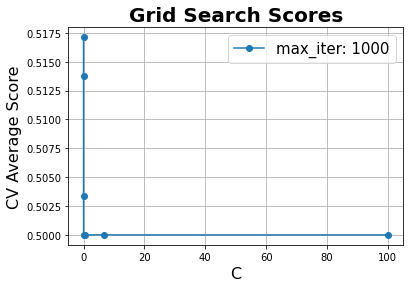

In [16]:
plot_grid_search(grid.cv_results_, params['C'], [1000], 'C', 'max_iter')

## Model on scaled PCA data

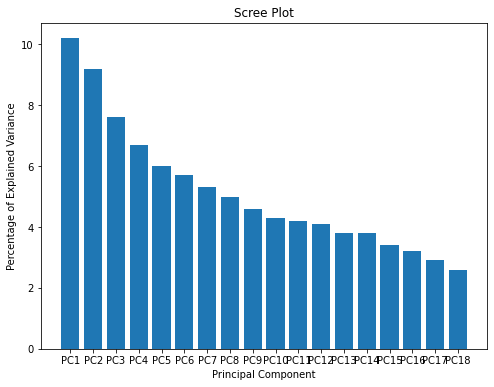

In [17]:
pca = PCA(0.9)
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
plt.figure(figsize=(8,6))
X_pca = pipe.fit_transform(X)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)] 
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

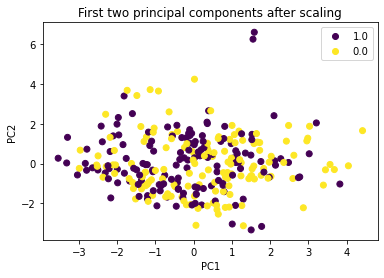

In [18]:
pca_df = pd.DataFrame(X_pca, index = X.index, columns = labels)
plot = plt.scatter(X_pca[:,0], X_pca[:,1], c=y)
legend = list(y.unique())
plt.legend(handles=plot.legend_elements()[0], labels=legend)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("First two principal components after scaling")
#for sample in pca_df.index:
#    plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))
plt.show()

In [19]:
clf = LogisticRegression(penalty = 'l2', max_iter = 1000)

grid = optimise(clf, params, X_pca, y, 0)
grid.best_score_

0.5205143191116306

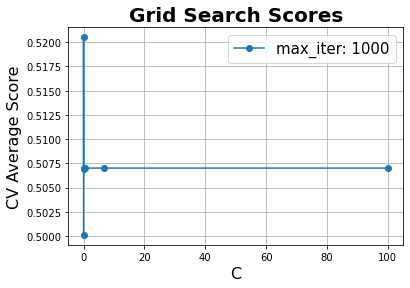

In [20]:
plot_grid_search(grid.cv_results_, params['C'], [1000], 'C', 'max_iter')

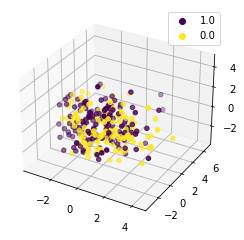

In [21]:
ax = plt.axes(projection='3d')
ax.scatter3D(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c = y)
plt.legend(handles=plot.legend_elements()[0], labels=list(y.unique()))
plt.show()

In [22]:
from sklearn import svm

svc = [svm.SVC(), {
        'C': [0.01,0.1,1,10,100],
        'kernel': ['rbf', 'sigmoid'],
        'gamma': [1,0.1,0.01,0.001]
        }]

In [23]:
grid = optimise(svc[0], svc[1], X, y, 10)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5; 1/40] START C=0.01, gamma=1, kernel=rbf................................
[CV 1/5; 1/40] END .C=0.01, gamma=1, kernel=rbf;, score=0.492 total time=   0.0s
[CV 2/5; 1/40] START C=0.01, gamma=1, kernel=rbf................................
[CV 2/5; 1/40] END .C=0.01, gamma=1, kernel=rbf;, score=0.492 total time=   0.0s
[CV 3/5; 1/40] START C=0.01, gamma=1, kernel=rbf................................
[CV 3/5; 1/40] END .C=0.01, gamma=1, kernel=rbf;, score=0.492 total time=   0.0s
[CV 4/5; 1/40] START C=0.01, gamma=1, kernel=rbf................................
[CV 4/5; 1/40] END .C=0.01, gamma=1, kernel=rbf;, score=0.492 total time=   0.0s
[CV 5/5; 1/40] START C=0.01, gamma=1, kernel=rbf................................
[CV 5/5; 1/40] END .C=0.01, gamma=1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 1/5; 2/40] START C=0.01, gamma=1, kernel=sigmoid............................
[CV 1/5; 2/40] END C=0.01, gamma=1, kernel=sigm

[CV 4/5; 12/40] END C=0.1, gamma=0.1, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 5/5; 12/40] START C=0.1, gamma=0.1, kernel=sigmoid..........................
[CV 5/5; 12/40] END C=0.1, gamma=0.1, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 1/5; 13/40] START C=0.1, gamma=0.01, kernel=rbf.............................
[CV 1/5; 13/40] END C=0.1, gamma=0.01, kernel=rbf;, score=0.492 total time=   0.0s
[CV 2/5; 13/40] START C=0.1, gamma=0.01, kernel=rbf.............................
[CV 2/5; 13/40] END C=0.1, gamma=0.01, kernel=rbf;, score=0.492 total time=   0.0s
[CV 3/5; 13/40] START C=0.1, gamma=0.01, kernel=rbf.............................
[CV 3/5; 13/40] END C=0.1, gamma=0.01, kernel=rbf;, score=0.492 total time=   0.0s
[CV 4/5; 13/40] START C=0.1, gamma=0.01, kernel=rbf.............................
[CV 4/5; 13/40] END C=0.1, gamma=0.01, kernel=rbf;, score=0.492 total time=   0.0s
[CV 5/5; 13/40] START C=0.1, gamma=0.01, kernel=rbf.............................
[CV 5/5; 1

[CV 3/5; 25/40] END ..C=10, gamma=1, kernel=rbf;, score=0.492 total time=   0.0s
[CV 4/5; 25/40] START C=10, gamma=1, kernel=rbf.................................
[CV 4/5; 25/40] END ..C=10, gamma=1, kernel=rbf;, score=0.492 total time=   0.0s
[CV 5/5; 25/40] START C=10, gamma=1, kernel=rbf.................................
[CV 5/5; 25/40] END ..C=10, gamma=1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 1/5; 26/40] START C=10, gamma=1, kernel=sigmoid.............................
[CV 1/5; 26/40] END C=10, gamma=1, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 2/5; 26/40] START C=10, gamma=1, kernel=sigmoid.............................
[CV 2/5; 26/40] END C=10, gamma=1, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 3/5; 26/40] START C=10, gamma=1, kernel=sigmoid.............................
[CV 3/5; 26/40] END C=10, gamma=1, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 4/5; 26/40] START C=10, gamma=1, kernel=sigmoid.............................
[CV 4/5; 26/40] END C=

[CV 4/5; 38/40] END C=100, gamma=0.01, kernel=sigmoid;, score=0.492 total time=   0.0s
[CV 5/5; 38/40] START C=100, gamma=0.01, kernel=sigmoid.........................
[CV 5/5; 38/40] END C=100, gamma=0.01, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 1/5; 39/40] START C=100, gamma=0.001, kernel=rbf............................
[CV 1/5; 39/40] END C=100, gamma=0.001, kernel=rbf;, score=0.525 total time=   0.0s
[CV 2/5; 39/40] START C=100, gamma=0.001, kernel=rbf............................
[CV 2/5; 39/40] END C=100, gamma=0.001, kernel=rbf;, score=0.525 total time=   0.0s
[CV 3/5; 39/40] START C=100, gamma=0.001, kernel=rbf............................
[CV 3/5; 39/40] END C=100, gamma=0.001, kernel=rbf;, score=0.492 total time=   0.0s
[CV 4/5; 39/40] START C=100, gamma=0.001, kernel=rbf............................
[CV 4/5; 39/40] END C=100, gamma=0.001, kernel=rbf;, score=0.525 total time=   0.0s
[CV 5/5; 39/40] START C=100, gamma=0.001, kernel=rbf............................
[CV 

In [24]:
grid.best_score_

0.5441846873173583

In [25]:
grid.best_params_

{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}